# Human PBMCs from Sun et al.

Here we analyse sample 3_TB PBMCs from a healthy donor published by [Sun et al.](https://www.nature.com/articles/s41467-019-09639-3)
Link to the dataset: [GSM3665018](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3665018)

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
anndata2ri                  1.1
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cffi                        1.15.0
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.6.3
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.10.0
google                      NA
h5py                        3.7.0
hypergeom_ufunc             NA
igraph                      0.10.1
ipykernel                   6.15.1
ipython_genutils            0.2.0
ipywidgets                  8.0.1
jedi                        0.18.1
jinja2                      3.1.2
joblib                      1.1.0
kiwisolver                  1.4.4
llvmlite                    0.39.0
louvain                     0.8.0
markupsafe     

In [3]:
# install some R packages through rpy2 (the rest are installed via conda)
packnames = ('RColorBrewer', 'gam', 'ggplot2', 'plyr')
from rpy2.robjects.vectors import StrVector
#utils.install_packages(StrVector(packnames))
results_file = './write/Sun3_pbmcs.h5ad'  # the file that will store the analysis results

In [4]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)

In [5]:
## Load previously processed dataset
#adata = sc.read_h5ad(results_file)
#adata.obs.index.names = ['barcode']

In [6]:
# Set up data loading
file_base = '../../Munich/datasets/human/Sun_PBMC/sample3_TB/GSM3665018_TB_PBL_'
data_file_end = 'matrix.mtx.gz'
barcode_file_end = 'barcodes.tsv.gz'
gene_file_end = 'genes.tsv.gz'

In [7]:
# Data set load & annotation
#Parse Filenames
data_file = file_base+data_file_end
barcode_file = file_base+barcode_file_end
gene_file = file_base+gene_file_end

#Load data
adata = sc.read(data_file, cache=True)
adata = adata.transpose()
adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes

genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes

... reading from cache file cache/..-..-Munich-datasets-human-Sun_PBMC-sample3_TB-GSM3665018_TB_PBL_matrix.h5ad


In [8]:
adata

AnnData object with n_obs × n_vars = 2410 × 32738
    var: 'gene_id'

In [9]:
adata.var.head()

,gene_id
gene_symbol,
MIR1302-10,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945


In [10]:
adata.var_names_make_unique()

In [11]:
# Checking the total size of the data set
adata.shape

(2410, 32738)

# 1. Pre-processing and visualization

## 1.1 Quality control

In [12]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [13]:
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']


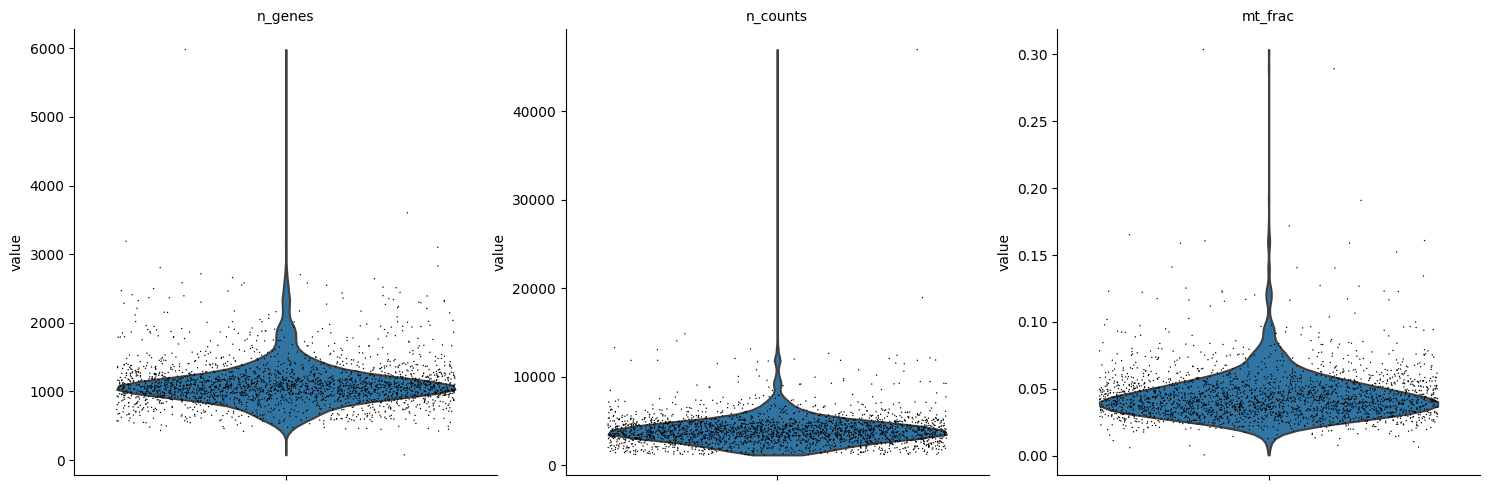

In [14]:
# Quality control - plot QC metrics
sc.pl.violin(adata, ['n_genes', 'n_counts', 'mt_frac'],
             jitter=0.4, multi_panel=True)

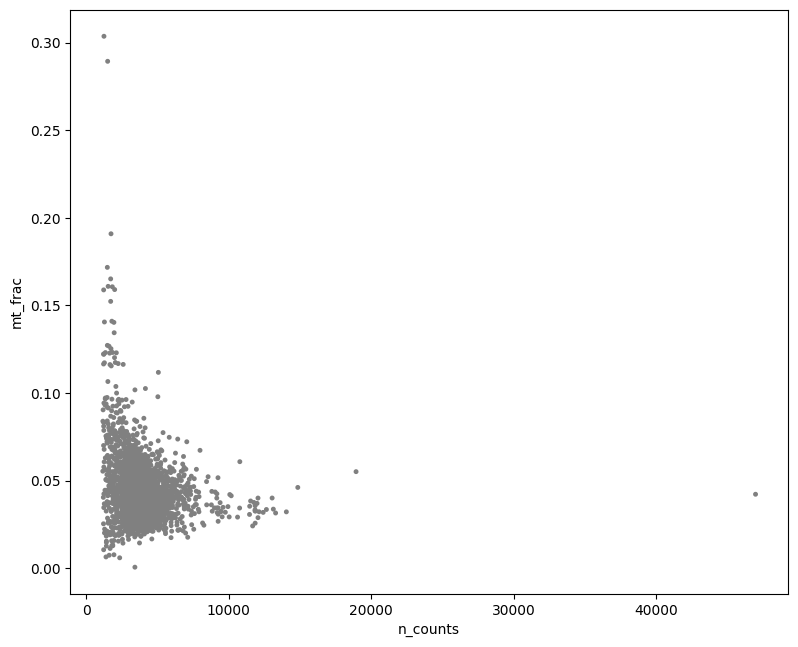

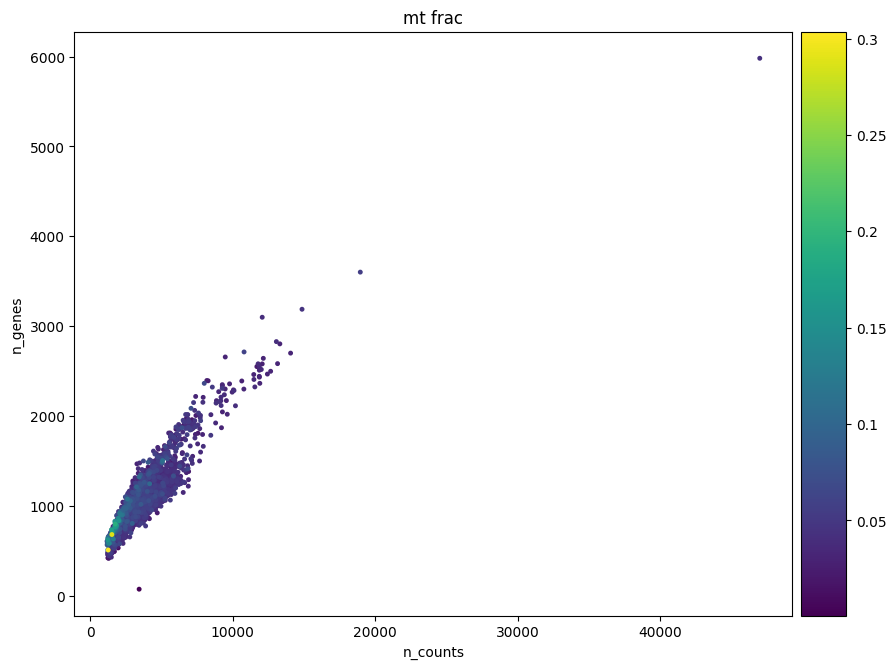

In [15]:
sc.pl.scatter(adata, x='n_counts', y='mt_frac')
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')

/home/xujing/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


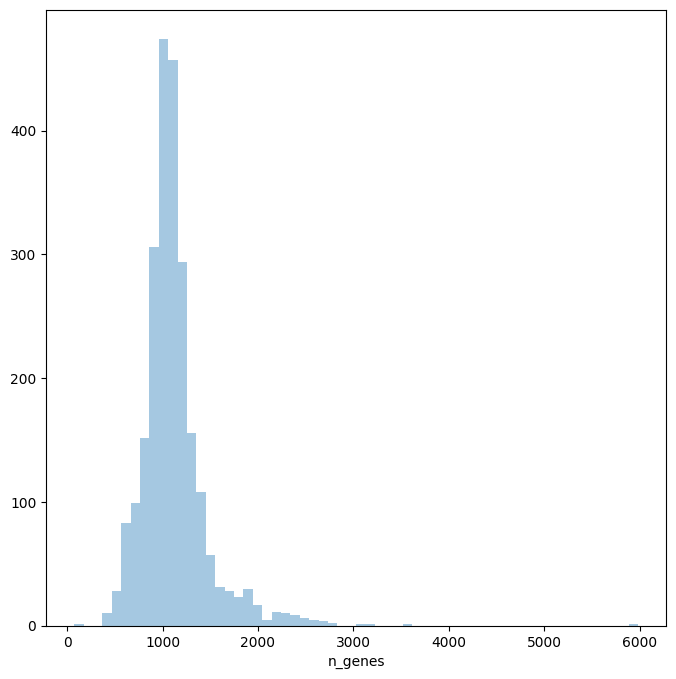

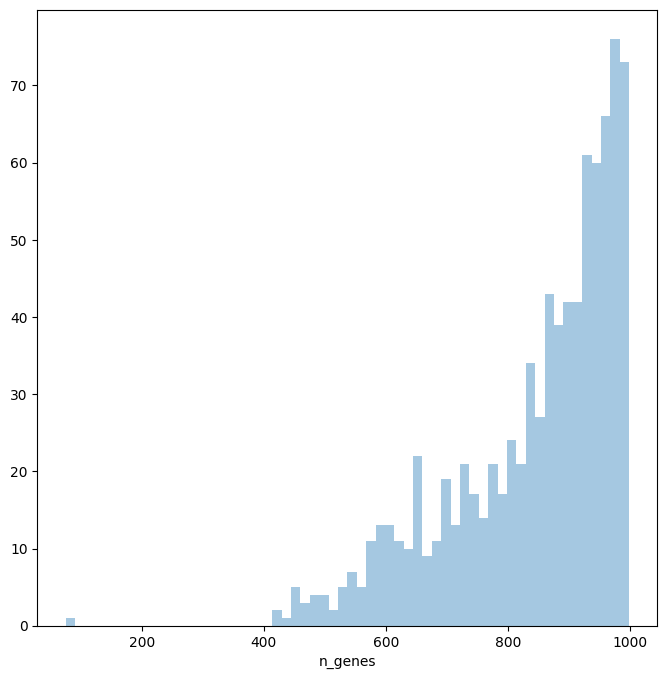

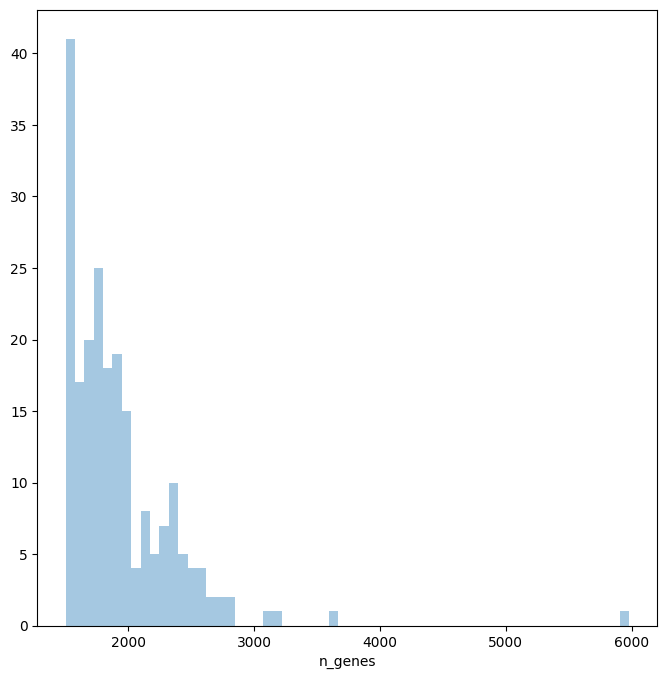

In [16]:
#Thresholding decision: genes
p1 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p2 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

p3 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']>1500], kde=False, bins=60)
plt.show()


In [17]:
# Thresholding on number of genes
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 400)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, max_genes = 3000)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 2410
filtered out 1 cells that have less than 400 genes expressed
Number of cells after gene filter: 2409
filtered out 4 cells that have more than 3000 genes expressed
Number of cells after gene filter: 2405


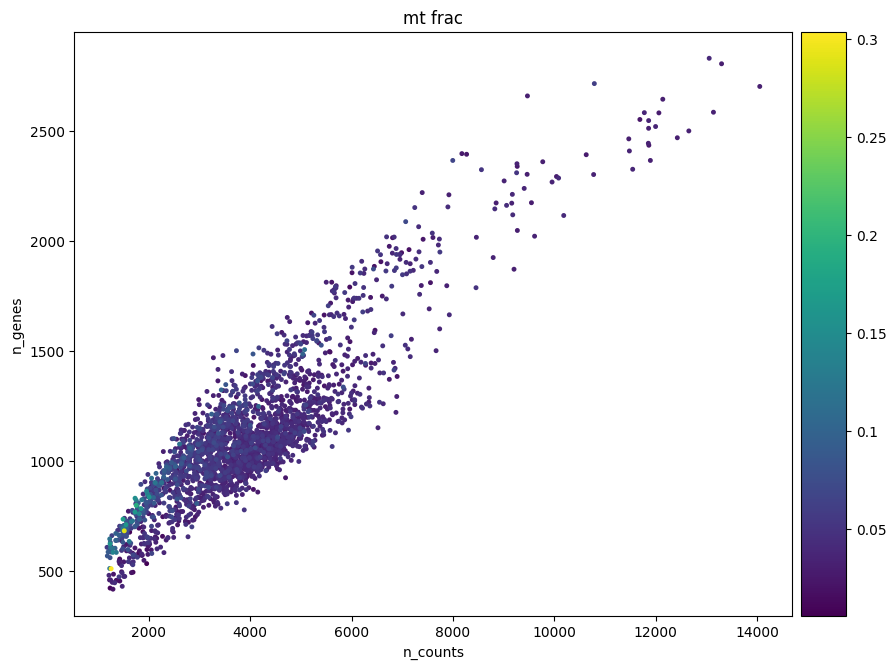

In [18]:
# Look at the effect of thresholding
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')


In [19]:
# Filter cells with high fraction of mitochondrial genes
print('Total number of cells: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))


Total number of cells: 2405
Number of cells after MT filter: 2403


In [20]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
# sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 32738
Number of genes after cell filter: 32738


## 1.2 Normalization

In [21]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
result_path = "./write/"
adata.to_df().to_csv(result_path + "Sun_3_PBMCs.csv")

sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 15


2022-11-24 13:01:05.293651: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 13:01:08.808987: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-24 13:01:20.013261: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-7/root/usr/lib64:/opt/rh/devtoolset-7/root/usr/lib:/opt/rh/devtoolset-7/root/usr/lib64/dyninst:/opt/rh/devtoolset-7/root/usr/lib/dyninst:/opt/rh/devtoolset-7/root/usr/lib64:/opt/rh/devtoolset-7

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:40)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [21]:
adata_pp.obs['groups'].value_counts()

0    566
1    412
2    395
3    394
4    287
5    149
6     81
7     69
8     35
9     15
Name: groups, dtype: int64

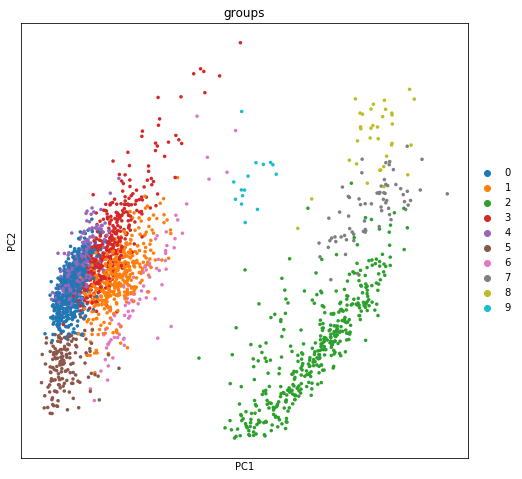

In [22]:
# Check that the smallest cluster (which is < 21) doesn't show any problem
sc.pl.pca_scatter(adata_pp, color='groups')

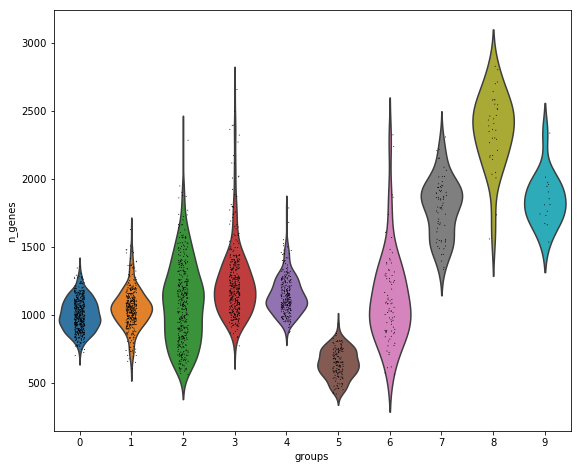

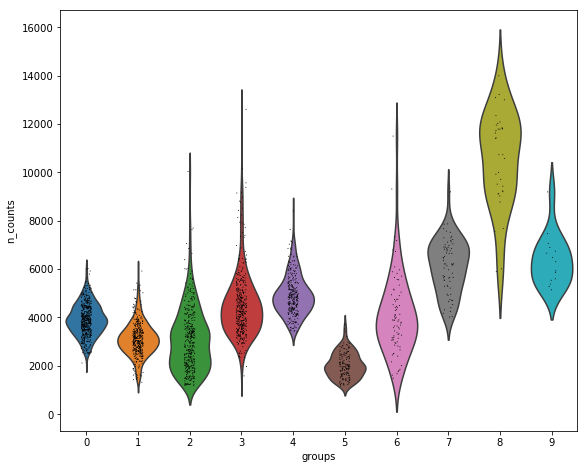

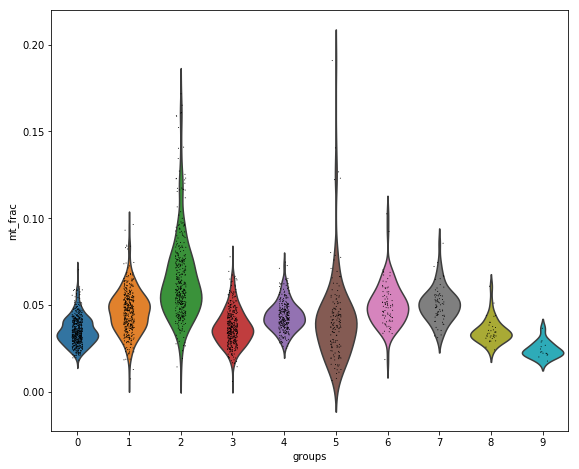

In [23]:
sc.pl.violin(adata_pp, 'n_genes', groupby= 'groups')
sc.pl.violin(adata_pp, 'n_counts', groupby= 'groups')
sc.pl.violin(adata_pp, 'mt_frac', groupby= 'groups')

In [24]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [25]:
# Having the smallest cluster size = 15 we need to pass sizes as input
sizes = input_groups.value_counts()

In [26]:
%%R -i data_mat -i input_groups -i sizes -o size_factors

size_factors = computeSumFactors(data_mat, sizes = sizes, clusters=input_groups, min.mean=0.1)

In [27]:
#Delete adata_pp
del adata_pp

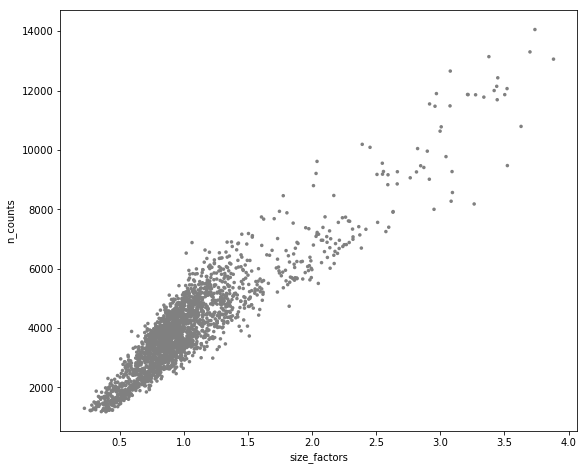

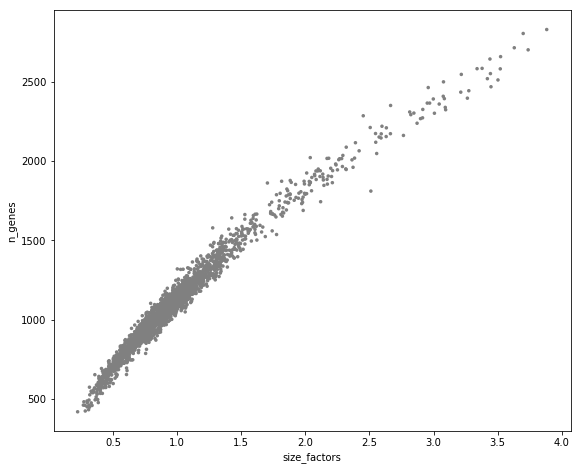

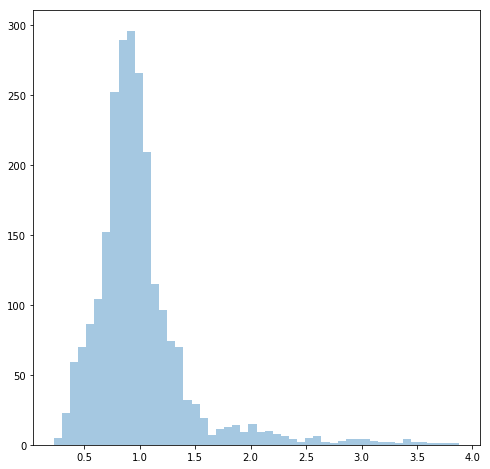

In [28]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [29]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [30]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [31]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

## 1.3 Highly variable genes

In [32]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 3999


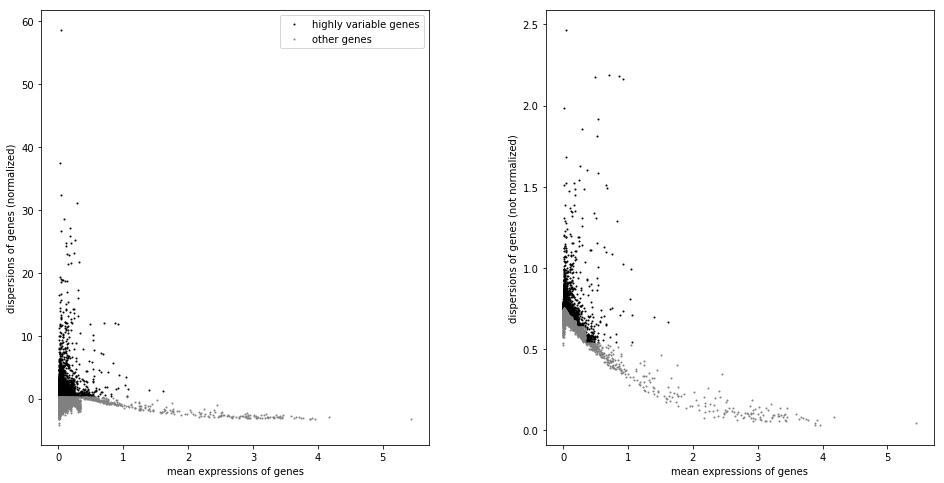

In [33]:
sc.pl.highly_variable_genes(adata)

# 2. Visualization

In [34]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9997458  0.9975038  0.99134344 0.98825896 0.9876082
     0.98235023 0.96597236 0.9464504  0.92429066 0.91750103 0.9045329
     0.87804615 0.86209416 0.83787525]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:01)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:24)


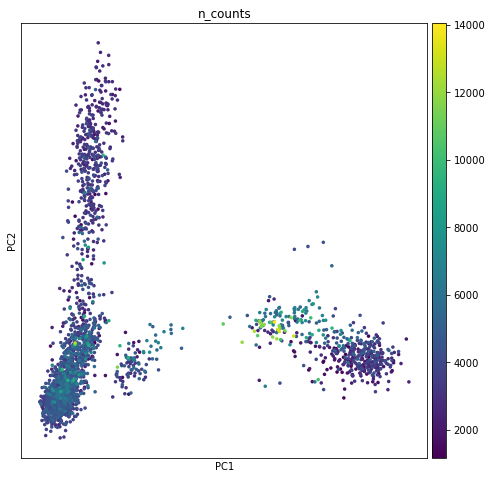

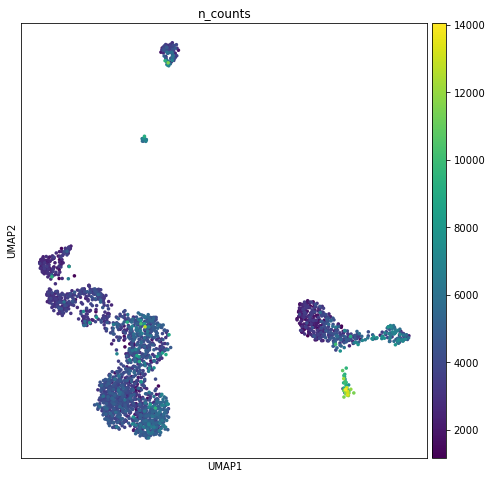

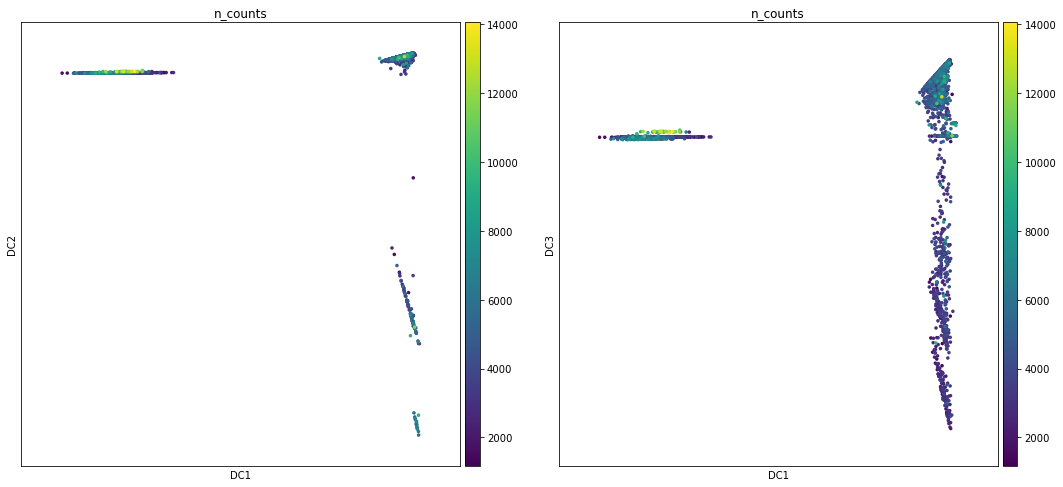

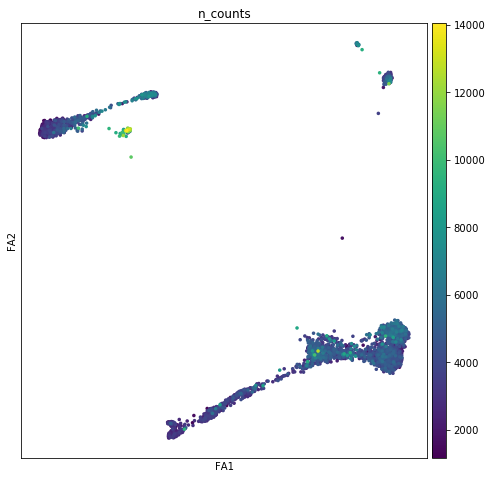

In [35]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

In [36]:
adata.write(results_file)

# 3. Clustering

In [37]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)


In [38]:
adata.obs['louvain_r1'].value_counts()

0    567
1    485
2    372
3    354
4    281
5    119
6     91
7     81
8     36
9     17
Name: louvain_r1, dtype: int64

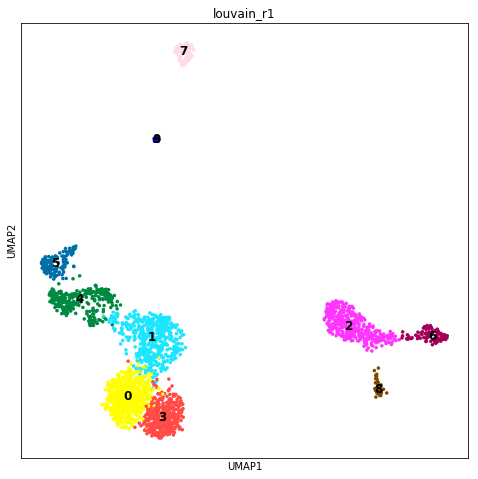

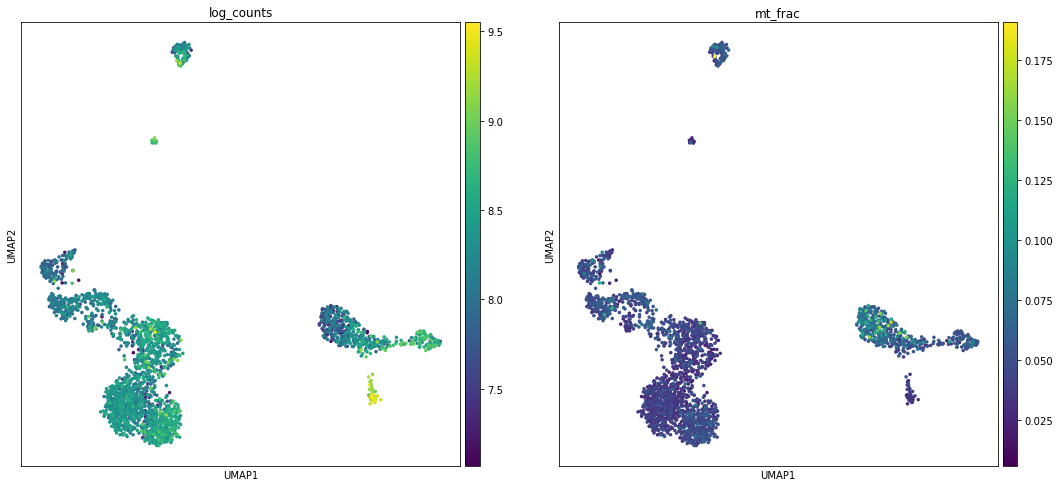

In [39]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1'], palette=sc.pl.palettes.default_64, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])

# 4. Marker genes and cluster annotation

In [40]:
#Calculate marker genes r1
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')

ranking genes
    finished: added to `.uns['rank_genes_r1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


## 4.1 List of markers of cell types from PanglaoDB
Here we use a list of markers for 34 different cell types from PanglaoDB, considering all cell types in "immune system" + "blood" + "bone". We manually checked that all cell types were possible for healthy tissue, so we excluded:
* __Myeloid derived suppressor cells__, description: MDSC are not present at steady state in healthy individuals and appear in cancer and pathological conditions associated with chronic inflammation or stress. 
* __Red pulp macrophages__, description: Present in the red pulp of the spleen. They are necessary for maintaining blood homeostasis by performing phagocytosis upon injured and senescent erythrocytes and blood-borne particulates.

In [41]:
markers_df = pd.read_csv('../../../Munich/Immune_markers_PanglaoDB.txt', delimiter='\t')
markers_df.shape

(2089, 14)

In [42]:
markers_df = markers_df[markers_df['cell.type'] != 'Myeloid-derived suppressor cells']
markers_df.shape

(2072, 14)

In [43]:
markers_df = markers_df[markers_df['cell.type'] != 'Red pulp macrophages']
markers_df.shape

(2060, 14)

In [44]:
markers_df_hum = markers_df[(markers_df['species'] == 'Hs') | (markers_df['species'] == 'Mm Hs')]
markers_df_hum.shape

(1907, 14)

In [45]:
cell_types = list(markers_df_hum['cell.type'].unique())

In [46]:
markers_dict = {}
for ctype in cell_types:
    df = markers_df_hum[markers_df_hum['cell.type'] == ctype]
    markers_dict[ctype] = df['official.gene.symbol'].to_list()

In [47]:
cell_annotation = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r1')

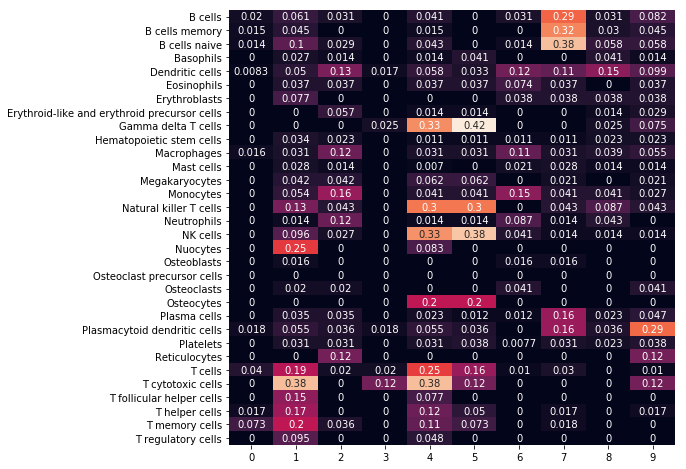

In [48]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r1', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

# 5. Plot makers of subtypes

In [49]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## T cells
We want to annotate CD8+ versus CD4+ cells.
For the labels to be consistent with the MCA-derived, we check the expression of those markers as well (when possible).

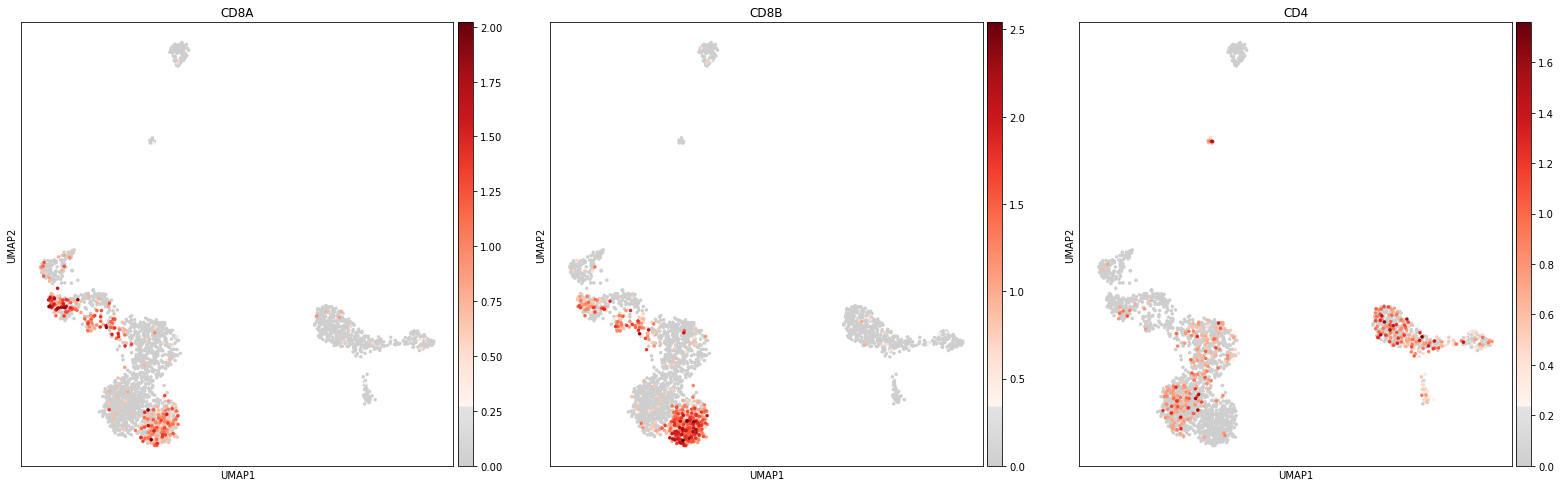

In [52]:
#Canonical markers
sc.pl.umap(adata, color=['CD8A','CD8B', 'CD4'], use_raw=False, color_map=mymap, size = 50)

# Markers from MCA
#sc.pl.umap(adata, color=['TRBC2'], use_raw=False, color_map=mymap, size = 20)

Cluster 0 and 1 are  CD4+ T cells. Cluster 3 is CD8+. 

### Natural killer T cells and NK cells
We consider NK cells as CD8- CD4-. NKT cells are instead CD8+/CD4+ and NKG7/GZMA +.

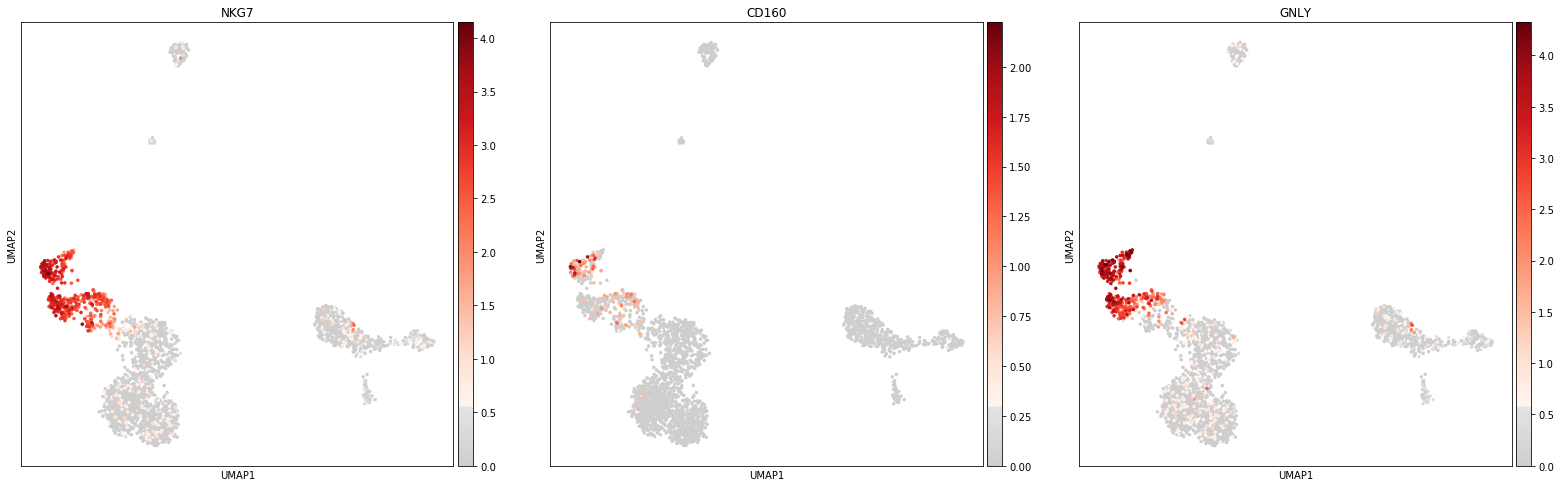

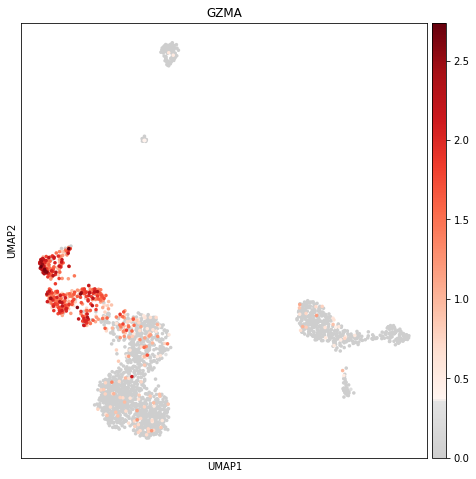

In [53]:
sc.pl.umap(adata, color=['NKG7','CD160', 'GNLY'], use_raw=False, color_map=mymap)

# marker from MCA
sc.pl.umap(adata, color=['GZMA'], use_raw=False, color_map=mymap)

NKT are present in cluster 4. NK cells in cluster 5 and part of 4 (subcluster!).

## Monocytes: CD14+ and CD16+

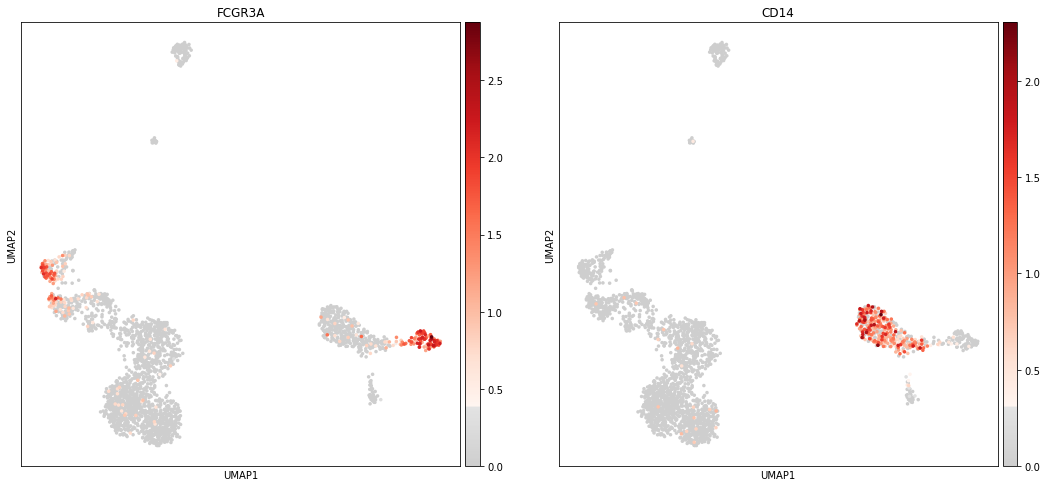

In [54]:
sc.pl.umap(adata, color=['FCGR3A','CD14'], use_raw=False, color_map=mymap)

## Monocyte-derived Dendritic cells
Markers from [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

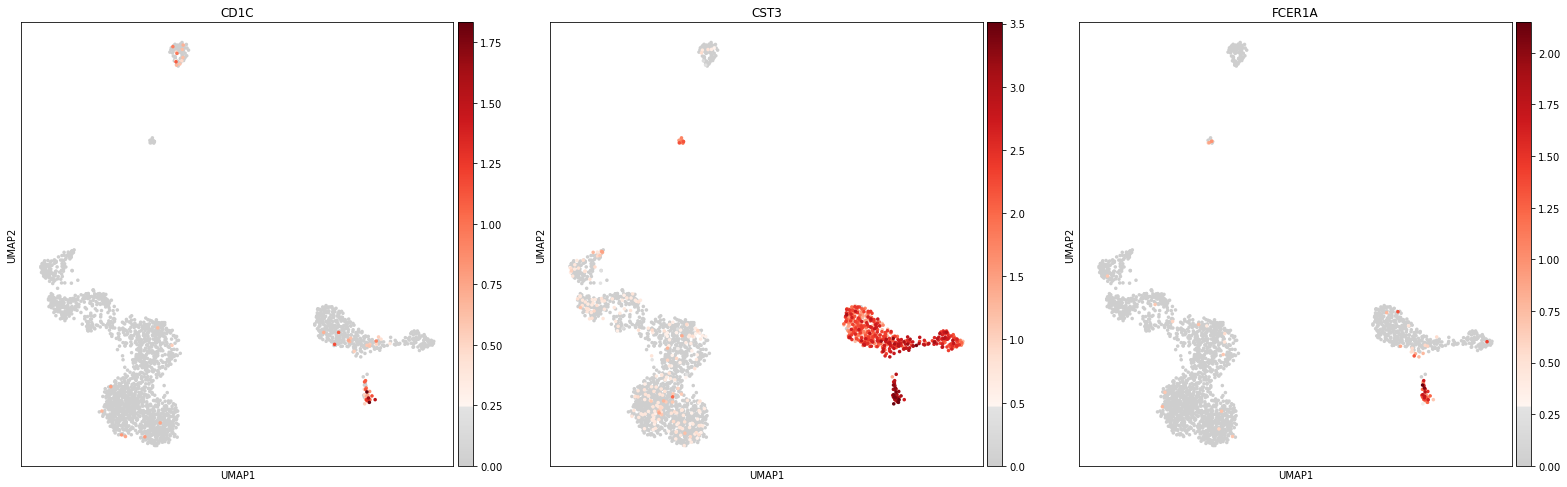

In [55]:
sc.pl.umap(adata, color=['CD1C', 'CST3', 'FCER1A'], use_raw=False, color_map=mymap)

## Plasmacytoid dendritic cells

Here we use markers from [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

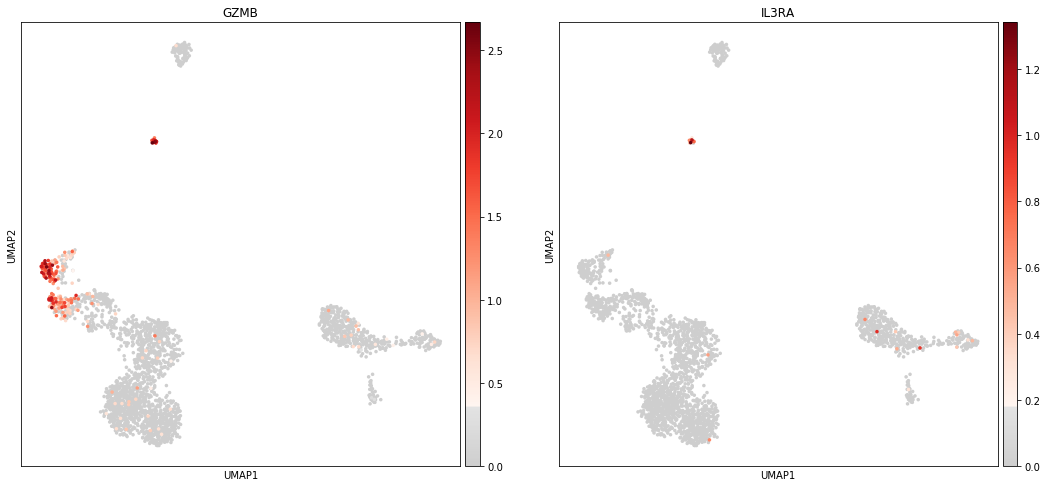

In [56]:
sc.pl.umap(adata, color=['GZMB', 'IL3RA'], use_raw=False, color_map=mymap)

## B cells
Oetjen et al. annotates B cells as CD20+ (MS4A1) or CD10+ (MME).

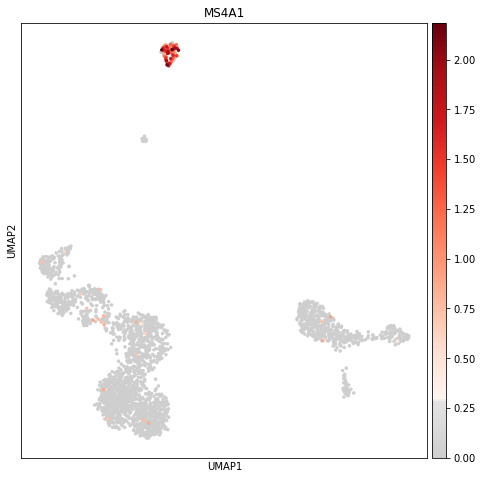

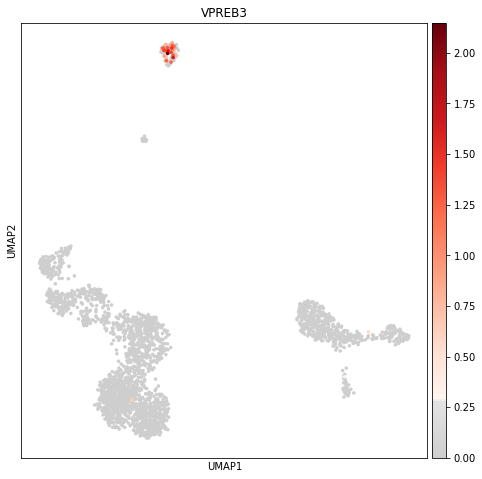

In [57]:
# MME not there
sc.pl.umap(adata, color=['MS4A1'], use_raw=False, color_map=mymap)

# markers from MCA
sc.pl.umap(adata, color=['VPREB3'], use_raw=False, color_map=mymap)

# 6. Subclustering

We subcluster clusters 4.

In [61]:
#Subcluster cluster4
sc.tl.louvain(adata, restrict_to=('louvain_r1', ['4']), resolution=0.4, key_added='louvain1_sub_4')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain1_sub_4', the cluster labels (adata.obs, categorical) (0:00:00)


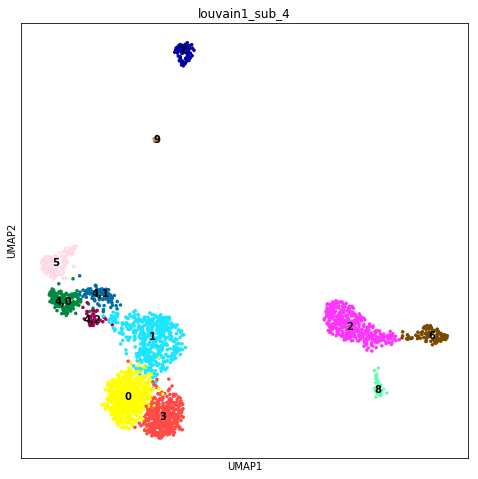

In [62]:
#Show the new clustering
sc.pl.umap(adata, color='louvain1_sub_4',  legend_loc = 'on data', palette=sc.pl.palettes.godsnot_64)

# 7. Final cell-type annotation

In [63]:
# Categories to rename
adata.obs['final_annotation'] = adata.obs['louvain1_sub_4']
adata.rename_categories('final_annotation', ['CD4+ T cells, 1', 
                                             'CD4+ T cells, 2',
                                             'CD14+ Monocytes', 
                                             'CD8+ T cells',
                                             'NKT cells,1',
                                             'NK cells,1',
                                             'NKT cells,2',
                                             'NK cells,2',
                                             'CD16+ Monocytes',
                                             'CD20+ B cells', 
                                             'Monocyte-derived dendritic cells',
                                             'Plasmacytoid dendritic cells'])

In [64]:
tmp = adata.obs['final_annotation']
tmp = ['CD4+ T cells' if item.startswith('CD4+ T ') else item for item in tmp]
tmp = ['NKT cells' if item.startswith('NKT cells') else item for item in tmp]
tmp = ['NK cells' if item.startswith('NK cells') else item for item in tmp]
adata.obs['final_annotation'] = tmp

... storing 'final_annotation' as categorical


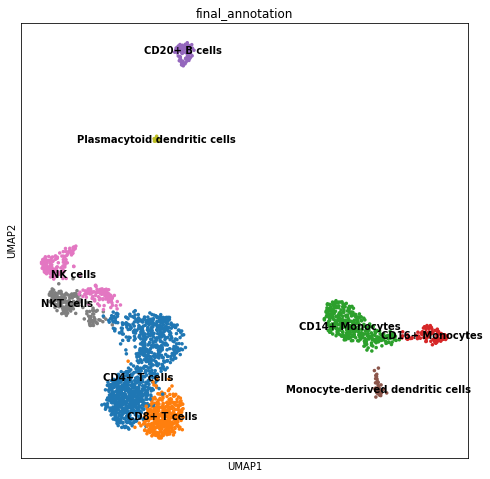

In [65]:
sc.pl.umap(adata, color='final_annotation', legend_loc='on data')

In [66]:
# save final result
adata.write(results_file)